In [31]:
from sklearn import svm
import numpy as np
import argparse
import cv2
import os
import random
import skimage.filters as fr
import skimage.io as io
from commonfunctions import *

############################
import joblib
import os.path
##########################
import skimage as sk
# Depending on library versions on your system, one of the following imports 
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_splitfrom commonfunctions import *
from matplotlib import pyplot as plt

In [32]:
path_to_dataset = r'dataset_mixed2\dataset_mixed'
target_img_size = (64, 64) # fix image size because classification algorithms THAT WE WILL USE HERE expect that

# We are going to fix the random seed to make our experiments reproducible 
# since some algorithms use pseudorandom generators
random_seed = 42  
random.seed(random_seed)
np.random.seed(random_seed)

In [33]:
def extract_features(img):
    
    """
    TODO
    You won't implement anything in this function. You just need to understand it 
    and understand its parameters (i.e win_size, cell_size, ... etc)
    """
 #   thr = fr.threshold_otsu(img)
 #   img = np.where(img > thr, 1, 0)
    img = cv2.resize(img, target_img_size)
    win_size = (64, 64)
    cell_size = (8, 8)
    block_size_in_cells = (4, 4)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins =4 # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    
    return h.flatten()

In [34]:
def load_dataset():
    features = []
    labels = []
    img_filenames = os.listdir(path_to_dataset)

    for i, fn in enumerate(img_filenames):
        if fn.split('.')[-1] != 'jpg' and fn.split('.')[-1] != 'bmp' and fn.split('.')[-1] != 'png' :
            continue

        label = fn.split('-')[0]
      #  print(label)
        labels.append(label)

        path = os.path.join(path_to_dataset, fn)
        img = cv2.imread(path)
        features.append(extract_features(img))
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(img_filenames)))
 
        
    return features, labels        

In [35]:
classifiers = {
    'SVM': svm.LinearSVC(random_state=random_seed)
}

In [36]:
# This function will test all our classifiers on a specific feature set
def run_experiment():
    
    # Load dataset with extracted features
    print('Loading dataset. This will take time ...')
    features, labels = load_dataset()
#    print(features)
#    print(labels)
    print('Finished loading dataset.')
    
    # Since we don't want to know the performance of our classifier on images it has seen before
    # we are going to withhold some images that we will test the classifier on after training 
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.2, random_state=random_seed)
    
    for model_name, model in classifiers.items():
        print('############## Training', model_name, "##############")
        # Train the model only on the training features
        model.fit(train_features, train_labels)
        # save the model to disk
        filename = 'finalized_model.sav'
        joblib.dump(model, filename)
        
        # Test the model on images it hasn't seen before
        accuracy = model.score(test_features, test_labels)
        print(model_name, 'accuracy:', accuracy*100, '%')



Loading dataset. This will take time ...
[INFO] processed 1000/9686
[INFO] processed 2000/9686
[INFO] processed 3000/9686
[INFO] processed 4000/9686
[INFO] processed 5000/9686
[INFO] processed 6000/9686
[INFO] processed 7000/9686
[INFO] processed 8000/9686
[INFO] processed 9000/9686
Finished loading dataset.
############## Training SVM ##############
SVM accuracy: 97.31682146542828 %


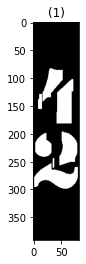

['4_2']


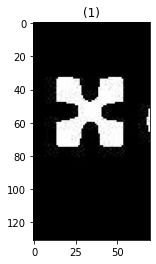

['_16']


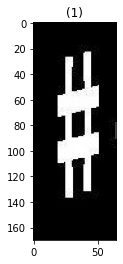

['#']


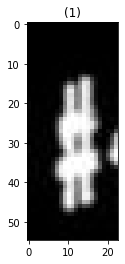

['#']


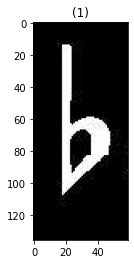

['&']


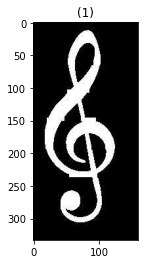

['[']


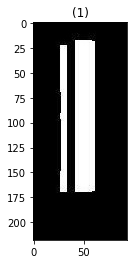

[']']


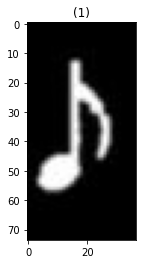

['_8']


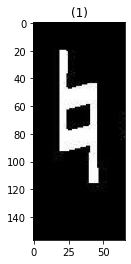

['']


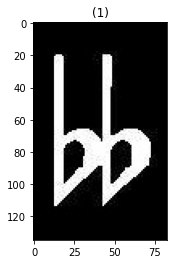

['&&']


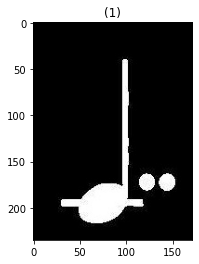

['c..']


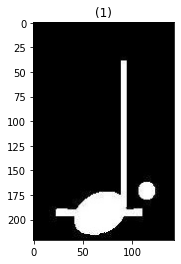

['c.']


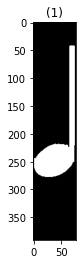

['_4']


In [37]:
if os.path.isfile('finalized_model.sav'):
    ##### the model already exit####
    print("model already exit")
else:
    ### not exit so train ###
    run_experiment()
    
##########################################    

 # load the model from disk
loaded_model = joblib.load('finalized_model.sav')
    # Example
testpathes=['20-1.png','##-1.jpg','#-1 (1).jpg','#-1 (2).jpg','&-0.jpg','[-0.jpg',']-1 (1).jpg','_8-0.jpg','-1.jpg','o.jpg','37389233_396700974895750_7474734536425302407_n.jpg' ,'13738923_396700974895750_7474734536425302407_n.jpg','5-1 (1).png']
for path in testpathes:
    img = cv2.imread( path )
    show_images([img])
    features = extract_features(img)
    print(loaded_model.predict([features]))
    

In [38]:
def check_chord_or_beam(img, staff_space):
    '''
        **img is assumed to be binarized
        returns:
            0 --> chord
            1 --> beam
           -1 --> neither
    '''

    se = sk.morphology.disk(staff_space//2)
    img = sk.morphology.binary_opening(img, se)
    img = sk.morphology.binary_erosion(img, se)
    img = sk.morphology.binary_erosion(img)
    se = sk.morphology.disk(staff_space//4)
    img = sk.morphology.binary_dilation(img, se)
    bounding_boxes = sk.measure.find_contours(img, 0.8)

    if len(bounding_boxes) < 2:
        return -1

    newImg = img.copy()
    centers, cnt = [], 0

    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = [np.min(box[:, 1]), np.max(
            box[:, 1]), np.min(box[:, 0]), np.max(box[:, 0])]
        rr, cc = sk.draw.rectangle(
            start=(Ymin, Xmin), end=(Ymax, Xmax), shape=newImg.shape)
        rr, cc = rr.astype(int), cc.astype(int)
        newImg[rr, cc] = 1
        centers.append([Ymin+Ymin//2, Xmin+Xmin//2])

    for i in range(1, len(centers)):
        if abs(centers[i][1] - centers[i-1][1]) > 70:
            cnt += 1

    if cnt == len(centers)-1:
        return 1
    else:
        return 0

In [39]:
img1 = io.imread("chords_2.png", as_gray=True)
print(check_chord_or_beam(img1, 17))
img2 = io.imread("beaming_4.png", as_gray=True)
print(check_chord_or_beam(img2,17))

0
1


In [40]:
def classfiyimg(img,staff_space):
    out=check_chord_or_beam(img, staff_space)
    if(out==-1):
        features = extract_features(img)
        print(loaded_model.predict([features]))
        
    